In [1]:
import os
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import time
from torch import nn
import cv2
from torchvision import transforms

In [2]:
# reference from CLAHE paper and cv2 documentation
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
    def __call__(self, img):
        # Convert PIL image to numpy array
        img_np = np.array(img)
        # Check if image is not grayscale, convert it
        if len(img_np.shape) == 3:
            img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_np
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        img_clahe = clahe.apply(img_gray)
        # If original image was RGB, replace the luminance component with the processed one
        if len(img_np.shape) == 3:
            img_clahe = cv2.cvtColor(img_np, cv2.COLOR_RGB2YCrCb)
            img_clahe[:,:,0] = clahe.apply(img_clahe[:,:,0])
            img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_YCrCb2RGB)
        # Convert numpy array back to PIL image
        img = Image.fromarray(img_clahe)
        return img

In [3]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True, transform=None):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        self.transform = transform
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
           img_nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
           raw_rgb = np.concatenate([raw_rgb, img_nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=False), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        if self.transform: 
            x = self.transform(x)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [4]:
# apply image augnmentation for the dataset
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    CLAHETransform(),
    transforms.ToTensor(),
])

In [5]:
base_path = Path("95-Cloud/95-cloud_training_only_additional_to38-cloud")
dataset = CloudDataset(base_path/'train_red_additional_to38cloud', 
                    base_path/'train_green_additional_to38cloud', 
                    base_path/'train_blue_additional_to38cloud', 
                    base_path/'train_nir_additional_to38cloud',
                    base_path/'train_gt_additional_to38cloud',
                    transform=data_transform)
len(dataset)

26301

In [6]:
# test x, y shape
x,y=dataset[1]
x.shape, y.shape

(torch.Size([3, 384, 384]), torch.Size([384, 384]))

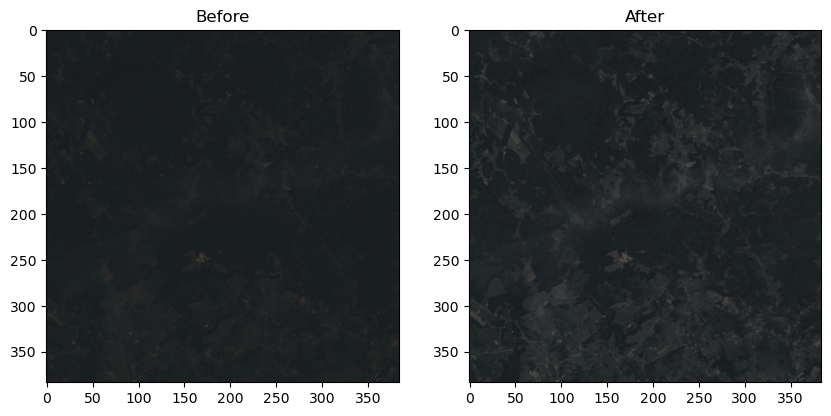

In [7]:
# plot a sample image of CLAHE transform
idx = 898
img, _ = dataset[idx]
mask = dataset.open_mask(idx)
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(dataset.open_as_array(idx))
ax[1].imshow(img.permute(1, 2, 0))
ax[0].set_title('Before')
ax[1].set_title('After')
plt.show()

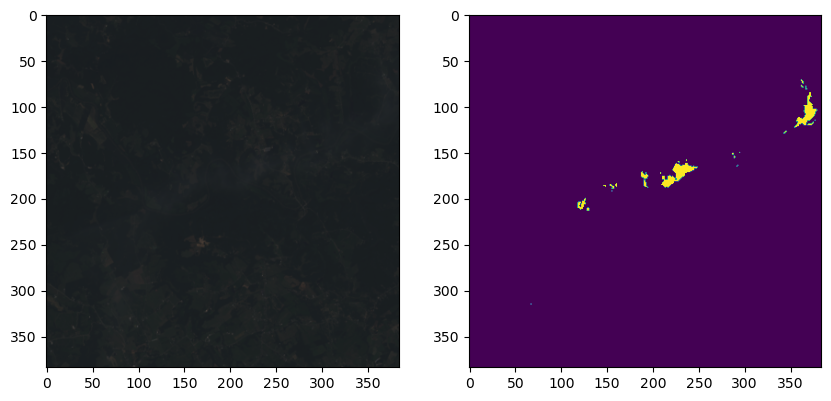

In [8]:
# plot a sample image
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(dataset.open_as_array(idx))
ax[1].imshow(dataset.open_mask(idx))
plt.show()

In [9]:
train_valid_size = int(0.8 * len(dataset))
train_size = int(0.8 * train_valid_size)
valid_size = train_valid_size - train_size
test_size = len(dataset) - train_valid_size
train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, (train_size, valid_size, test_size))
print(len(train_ds), len(valid_ds), len(test_ds))

16832 4208 5261


In [10]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True)

In [11]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([16, 3, 384, 384]), torch.Size([16, 384, 384]))

In [12]:
class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        


class RR_block(nn.Module):
    def __init__(self, ch_in, ch_out, t=2):
        super(RR_block, self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out, t=t),
            Recurrent_block(ch_out, t=t)
        )
        self.conv1= nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=0)

    def forward(self,x):
        x = self.conv1(x)
        x1 = self.RCNN(x)
        return x+x1

In [ ]:
class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=2,t=2):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.RCNN1 = RR_block(ch_in=img_ch,ch_out=32,t=t)
        self.RCNN2 = RR_block(ch_in=32,ch_out=64,t=t)
        self.RCNN3 = RR_block(ch_in=64,ch_out=128,t=t)
        self.RCNN4 = RR_block(ch_in=128,ch_out=256,t=t)

        self.upconv4 = self.expand_block(256, 128, 3, 1)
        self.upconv3 = self.expand_block(128*2, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, output_ch, 3, 1)


    def forward(self,x):
        # # encoding path
        x1 = self.RCNN1(x)
        x1 = self.Maxpool(x1)

        x2 = self.RCNN2(x1)
        x2 = self.Maxpool(x2)

        x3 = self.RCNN3(x2)
        x3 = self.Maxpool(x3)

        x4 = self.RCNN4(x3)
        x4 = self.Maxpool(x4)

        upconv4 = self.upconv4(x4)
        upconv3 = self.upconv3(torch.cat([upconv4, x3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, x2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, x1], 1))

        return upconv1
    
    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [16]:
unet = R2U_Net(3,2)
if torch.cuda.is_available():
    device = torch.device("cuda")
    unet = nn.DataParallel(unet) 
    unet.to(device)
else:
    device = torch.device("cpu")

In [17]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [18]:
count_parameters(unet)

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|  module.conv1.RCNN.0.conv.0.weight   |    9216    |
|   module.conv1.RCNN.0.conv.0.bias    |     32     |
|  module.conv1.RCNN.0.conv.1.weight   |     32     |
|   module.conv1.RCNN.0.conv.1.bias    |     32     |
|  module.conv1.RCNN.1.conv.0.weight   |    9216    |
|   module.conv1.RCNN.1.conv.0.bias    |     32     |
|  module.conv1.RCNN.1.conv.1.weight   |     32     |
|   module.conv1.RCNN.1.conv.1.bias    |     32     |
|   module.conv1.conv1.conv1.weight    |    864     |
|    module.conv1.conv1.conv1.bias     |     32     |
|    module.conv1.conv1.bn1.weight     |     32     |
|     module.conv1.conv1.bn1.bias      |     32     |
|   module.conv1.conv1.conv2.weight    |    9216    |
|    module.conv1.conv1.conv2.bias     |     32     |
|    module.conv1.conv1.bn2.weight     |     32     |
|     module.conv1.conv1.bn2

3657430

### Train

In [19]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    torch.cuda.empty_cache()
    model.cuda()
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

    train_loss, valid_loss = [], []

    best_acc = 0.0


    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.eval()  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss.detach()*dataloader.batch_size
                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
#         scheduler.step()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=1e-3)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=75)

In [ ]:
# convert tensor list to list
for i in range(len(train_loss)):
    train_loss[i] = float(train_loss[i].item())
    valid_loss[i] = float(valid_loss[i].item())

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()
plt.show()

### Sample Test

In [ ]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [ ]:
xb, yb = next(iter(test_dl))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

torch.Size([16, 2, 384, 384])

In [ ]:
bs = 16
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, jaccard_score

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

# Initialize accumulators
test_acc, test_precision, test_recall, test_f1, test_auc, test_jaccard = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
all_probs, all_targets = [], []
# Iterate over the test dataset
for xt, yt in test_dl:
    with torch.no_grad():
        predt = unet(xt.cuda())
    # Compute accuracy
    acc = acc_metric(predt, yt)
    test_acc += acc.item() * xt.size(0)
    # Reshape and process predictions and labels
    preds = predt.argmax(dim=1).view(-1).cpu().numpy()  # Convert to binary predictions and flatten
    labels = yt.view(-1).cpu().numpy()  # Flatten the ground truth labels
    # Accumulate all probabilities (for class 1) and true labels for AUC calculation
    probs = predt[:, 1, :, :].sigmoid().view(-1).cpu().numpy()
    all_probs.extend(probs)
    all_targets.extend(labels)
    # Calculate and accumulate precision, recall, F1, and Jaccard for each batch
    test_precision += precision_score(labels, preds) * xt.size(0)
    test_recall += recall_score(labels, preds) * xt.size(0)
    test_f1 += f1_score(labels, preds) * xt.size(0)
    test_jaccard += jaccard_score(labels, preds) * xt.size(0)
# Calculate averages over the entire test set
num_samples = len(test_dl.dataset)
test_acc = test_acc / num_samples
test_precision = test_precision / num_samples
test_recall = test_recall / num_samples
test_f1 = test_f1 / num_samples
test_jaccard = test_jaccard / num_samples
test_auc = roc_auc_score(all_targets, all_probs)
# Print the metrics
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Average Jaccard (IoU): {test_jaccard:.4f}")
print(f"AUC: {test_auc:.4f}")

### Save Model

In [ ]:
from datetime import datetime

now = datetime.now()
formatted_time = now.strftime("%m_%d_%Y_%H%M%S")
path = "models/r2_unet_" + formatted_time + "_acc_" + str(round(test_acc.item(), 4)) +".pth"
torch.save(unet, path)